# ToDo
добавить реальные роторы

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from tqdm.auto import tqdm, trange
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

In [3]:
import torch
import torch.nn as nn
from torchsummary import summary
from torch.utils.data import DataLoader

from sklearn.model_selection import train_test_split

In [4]:
mps_is_ok = torch.backends.mps.is_built() and torch.backends.mps.is_available()
device = torch.device('mps' if mps_is_ok else 'cpu')
print(device)

mps


In [5]:
device = torch.device("cpu")

In [6]:
import sys
sys.path.append("../src/")

from iou import find_split_indices, calculate_metrics
from datasets import RotorDataset
from utils import proba2class, standardize, label_smoothing
from models import Model_CNN_Dense

# Dataset

## Real

In [5]:
def split_filename(filename):
    # ex: M15-G3-S0-2.csv
    h, g, s, i = filename.split("-")
    h, g, s = map(lambda x: int(x[1:]), [h, g, s])
    i = int(i.split(".")[0])
    return h, g, s, i

In [6]:
folder_dataset = "/Users/andrey/Work/HPL/projects/rheeda/rotor-dataset/"

rows = []

for filename in os.listdir(folder_dataset):
    
    h, g, s, i = split_filename(filename)
    row = {
        "filename": filename,
        "heart": h,
        "group": g,
        "stim": s,
        "i": i
    }
    rows.append(row)
    
df_dataset = pd.DataFrame(rows)

In [209]:
mask_test = (df_dataset.heart == 13) & (df_dataset.group == 2)
mask_test |= (df_dataset.heart == 15) & (df_dataset.group == 3)

df_dataset["fold"] = "train"
df_dataset.loc[mask_test, "fold"] = "test"

In [210]:
class RotorDataset(Dataset):
    
    def __init__(
        self,
        folder_dataset,
        df_dataset,
        window_size=256,
        window_step=None,
        columns=None
    ):
        
        self.window_size = window_size
        self.window_step = window_size if window_step is None else window_step

        self.X = []
        self.Y = []
        
        df_concat = []        
        columns_xyz = ["x", "y", "z"]
        
        for _, row in tqdm(list(df_dataset.iterrows())):
            
            filename = os.path.join(
                folder_dataset,
                row.filename
            )
        
            df = pd.read_csv(filename)
            df = df[::10]
            
            df[columns_xyz] -= df[columns_xyz].iloc[0]
            
            if len(df_concat):
                df_last = df_concat[-1]
                df[columns_xyz] += df_last[columns_xyz].iloc[-1]
                
            df_concat.append(df)
            
        df_concat = pd.concat(df_concat, ignore_index=True)
        proba = df_concat["class"]
            
        for i in trange(0, len(df_concat) - self.window_size, self.window_step):                    
            x = df_concat[columns_xyz][i: i + window_size].values.T
            y = proba[i: i + window_size]
            self.X.append(x)        
            self.Y.append(y)
                
        self.N = len(self.X)

        self.X = np.stack(self.X)
        self.X = torch.tensor(self.X, dtype=torch.float32)
        
        self.Y = np.stack(self.Y)
        self.Y = torch.tensor(self.Y, dtype=torch.float32)
        # self.Y = nn.functional.one_hot(self.Y).float()
        
        self.df_concat = df_concat
                
    def __len__(self):
        return self.N

    def __getitem__(self, idx):
        x = self.X[idx]
        y = self.Y[idx]
        return x, y

In [211]:
WINDOW_SIZE = 256

dataset_train_real = RotorDataset(
    folder_dataset, 
    df_dataset[df_dataset.fold == "train"],
    window_size=WINDOW_SIZE,
    window_step=WINDOW_SIZE // 2
)

  0%|          | 0/170 [00:00<?, ?it/s]

  0%|          | 0/572 [00:00<?, ?it/s]

In [212]:
dataset_test_real = RotorDataset(
    folder_dataset, 
    df_dataset[df_dataset.fold == "test"],
    window_size=WINDOW_SIZE,
    window_step=WINDOW_SIZE // 2
)

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/225 [00:00<?, ?it/s]

## Synthetic

In [7]:
filename = "../data/synthetic-latest.csv"
df = pd.read_csv(
    filename,
    # nrows=10_000
)

In [8]:
xyz = ["x", "y", "z"]
df[xyz] = df[xyz].diff()
df.dropna(inplace=True)

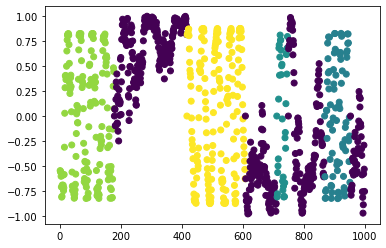

In [9]:
plt.scatter(df.index[:1_000], df.y[:1_000], c=df["proba"][:1_000])

In [10]:
i_train = len(df) * 8 // 10
WINDOW_SIZE = 128
WINSOW_STEP = WINDOW_SIZE // 8
dataset_train = RotorDataset(
    pd.concat([df[:i_train], df[:i_train][:-1]]),
    window_size=WINDOW_SIZE,
    window_step=WINSOW_STEP
)

dataset_test = RotorDataset(
    pd.concat([df[i_train:], df[i_train:][::-1]]),
    window_size=WINDOW_SIZE,
    window_step=WINSOW_STEP
)

  0%|          | 0/15354 [00:00<?, ?it/s]

  0%|          | 0/3833 [00:00<?, ?it/s]

In [11]:
dataset_train.X += torch.rand_like(dataset_train.X) / 10
dataset_test.X += torch.rand_like(dataset_test.X) / 10

In [12]:
dataset_train.X.shape

torch.Size([15354, 3, 128])

In [13]:
dataset_train.Y.shape

torch.Size([15354, 128])

In [14]:
x, y = dataset_train[32]

In [15]:
y.shape

torch.Size([128])

In [16]:
metrics, df_metrics = calculate_metrics(
    proba2class(y).detach().numpy(),
    proba2class(y).detach().numpy()
)

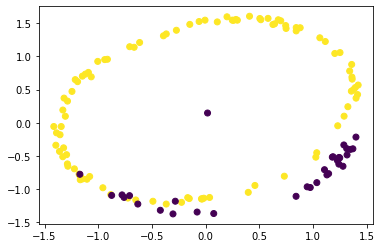

In [17]:
plt.scatter(x[0], x[1], c=y, vmin=0, vmax=1)

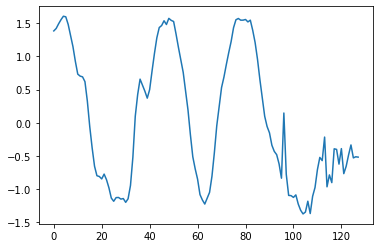

In [18]:
plt.plot(x[1])

In [19]:
batch_size = len(dataset_train) // 100
train_dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

# Model

In [20]:
model = Model_CNN_Dense(WINDOW_SIZE)
summary(model, (3, WINDOW_SIZE))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 16, 128]             352
       BatchNorm1d-2              [-1, 16, 128]              32
              ReLU-3              [-1, 16, 128]               0
            Conv1d-4              [-1, 16, 128]           1,808
       BatchNorm1d-5              [-1, 16, 128]              32
              ReLU-6              [-1, 16, 128]               0
         MaxPool1d-7               [-1, 16, 64]               0
            Conv1d-8               [-1, 16, 64]           1,808
       BatchNorm1d-9               [-1, 16, 64]              32
             ReLU-10               [-1, 16, 64]               0
           Conv1d-11               [-1, 16, 64]           1,808
      BatchNorm1d-12               [-1, 16, 64]              32
             ReLU-13               [-1, 16, 64]               0
        MaxPool1d-14               [-1,

In [21]:
x = dataset_train.X[:1]
y = dataset_train.Y[:1]

In [22]:
def trim(*args, margin=0):
    if margin == 0:
        return args
    else:
        return [arg[..., margin: -margin] for arg in args]


# def calculate_loss(y1, y2):    
#     loss = nn.functional.binary_cross_entropy(*trim(y1, y2))
#     return loss

def calculate_loss(y_pred, y_true):
    return nn.functional.binary_cross_entropy(
        y_pred,
        label_smoothing(y_true, 0.1)
    )

y_pred = model(x)
calculate_loss(y_pred, y)

tensor(0.7126, grad_fn=<BinaryCrossEntropyBackward0>)

In [23]:
from sklearn.metrics import balanced_accuracy_score, accuracy_score

def accuracy(y_pred, y_true, balanced=False):
    y_pred, y_true = trim(y_pred, y_true)
    f = balanced_accuracy_score if balanced else accuracy_score
    return f(
        proba2class(y_true).flatten(),
        proba2class(y_pred).flatten()
    )

In [24]:
accuracy(y_pred, y)

0.4921875

In [25]:
calculate_metrics(
    proba2class(y_pred.view(-1)).detach().numpy(),
    proba2class(y.view(-1)).detach().numpy()
)[0]

{'n_diff': 31,
 'iou_mean': 0.01513671875,
 'iou_std': 0.008404369505757974,
 'offset_mean': -70.0,
 'offset_std': 36.30693526569127,
 'onset_mean': 56.0625,
 'onset_std': 36.14124397594848}

# Train

In [26]:
def train_model_loss_only(
    model,
    dataloader,
    *,
    optimizer,
    criterion,
    device
):
    
    losses = []
    
    model.train()

    for X, Y in dataloader:
        
        X = X.to(device)
        Y = Y.to(device)  
        
        optimizer.zero_grad()
        
        Y_pred = model.forward(X)
        
        loss = criterion(Y_pred, Y)
        losses.append(loss.item())
        
        loss.backward()

        optimizer.step()

    loss = torch.mean(
        torch.tensor(losses)
    )
        
    return loss


def train_model(model, dataloader):
    
    losses = []
    scores = []
    
    model.train()

    for X, Y in dataloader:
        
        X = X.to(device)
        Y = Y.to(device)  
        
        optimizer.zero_grad()
        
        Y_pred = model.forward(X)
        
        loss = calculate_loss(Y_pred, Y)
        
        loss.backward()
        
        optimizer.step()

        with torch.no_grad():
            score = accuracy(Y_pred, Y)
        
        losses.append(loss.item())
        scores.append(score)
        
#     y_true_list = torch.vstack(y_true_list)
#     y_pred_list = torch.vstack(y_pred_list)
    
#     with torch.no_grad():
#         model.eval()
#         loss = calculate_loss(y_pred_list, y_true_list).item()
#         score = accuracy(y_pred_list, y_true_list)

    loss = np.mean(losses)
    score = np.mean(scores)
        
    return loss, score

In [27]:
def test_model(model, dataloader):
    
    losses = []
    scores = []
    
    metrics_all = []
    n_diffs = []
    
    with torch.no_grad():

        model.eval()
        
        for X, y_true in dataloader:
            
            X = X.to(device)
            y_true = y_true.to(device)  
            y_pred = model(X)
            loss = calculate_loss(y_pred, y_true).item()
            score = accuracy(y_pred, y_true)
            
            losses.append(loss)
            scores.append(score)
            
            for pred, true in zip(y_pred, y_true):
                                
                metrics, df_metrics = calculate_metrics(
                    proba2class(pred.view(-1)).detach().numpy(),
                    proba2class(true.view(-1)).detach().numpy()
                )
                
                if metrics is None:
                    continue
                
                metrics_all.append(df_metrics)
                n_diffs.append(metrics["n_diff"])
                
    loss = np.mean(losses)
    score = np.mean(scores)
    
    metrics_all = pd.concat(metrics_all)
    metrics = metrics_all.mean().to_dict()
    metrics["n_diff"] = np.mean(n_diffs)
        
    return loss, score, metrics

In [28]:
def train_epoch(model, optimizer):
    
    objectives = {}
    
    # Train
    
    loss, score = train_model(
        model,
        train_dataloader
    )
    
    objectives["loss_train"] = loss
    objectives["score_train"] = score
    
    # Test

    loss, score, metrics = test_model(model, test_dataloader)
    objectives["loss_test"] = loss
    objectives["score_test"] = score
    
    objectives.update(metrics)

    return objectives

# Train

In [29]:
model = Model_CNN_Dense(
    WINDOW_SIZE,
    n_stack=3,
    hidden_channels=16,
    kernel=7
)

score_test_best = 0.
rows = []

In [30]:
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=1e-3
)

In [31]:
model.to(device);

In [56]:
filename_model_save = "../models/rad-v3.0-arkit-latest.st"


with trange(10) as t:
    for epoch in t:
        
        objectives = train_epoch(model, optimizer)
        rows.append(objectives)
        
        score_test = objectives["score_test"]
        if score_test > score_test_best:
            score_test_best = score_test
            # torch.save(model.state_dict(), filename_model_save)

        t.set_postfix(
            train=objectives["score_train"],
            test=score_test,
            best=score_test_best
        )

  0%|          | 0/10 [00:00<?, ?it/s]

In [57]:
df_progress = pd.DataFrame(rows)

In [58]:
df_progress

,loss_train,score_train,loss_test,score_test,ref,iou,offset,onset,intersection,union,n_diff
0,0.466771,0.789695,0.391776,0.873696,0.806293,0.265608,-35.422127,38.470820,31.370569,111.718224,2.287558
1,0.333152,0.918435,0.326172,0.915962,0.858453,0.479912,-26.220865,25.911959,54.763359,110.318066,0.981682
2,0.301566,0.938904,0.303114,0.936634,0.794105,0.584548,-18.826039,20.163989,65.782825,107.906371,0.821212
3,0.282686,0.950483,0.308212,0.932082,0.655462,0.717217,-8.393162,11.557387,79.947497,105.006716,0.787840
4,0.269052,0.959445,0.291623,0.943590,0.759584,0.721419,-10.171340,11.907788,79.590654,105.401869,0.603509
5,0.260008,0.964847,0.287849,0.945534,0.728033,0.744212,-9.589400,11.450830,81.849936,105.893997,0.631061
6,0.253796,0.968808,0.313609,0.930288,0.930642,0.610077,-20.352474,19.222969,67.219304,108.152108,0.571927
7,0.249590,0.971749,0.287428,0.947473,0.895634,0.654875,-17.790725,16.304400,71.453032,107.090369,0.532233
8,0.248129,0.972316,0.291545,0.945601,0.825900,0.737634,-10.573195,11.657775,80.614834,106.092388,0.466027
9,0.242184,0.976402,0.312194,0.937276,0.741319,0.835375,-4.900883,5.640869,91.321792,105.714189,0.435144


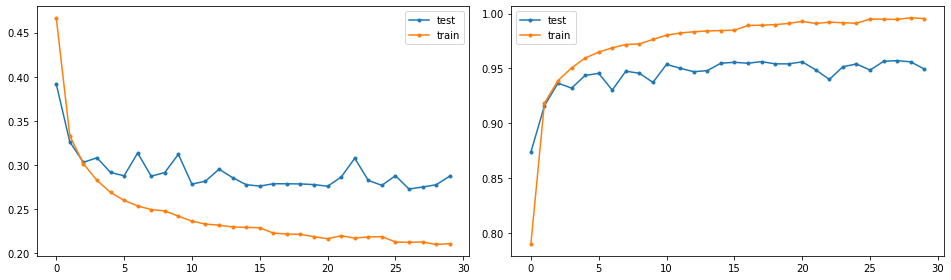

In [59]:
fig, axes = plt.subplots(ncols=2, figsize=plt.figaspect(0.3))

for i, key in enumerate(["loss", "score"]):

    ax = axes[i]
    plt.sca(ax)

    for t in "test", "train":
        plt.plot(df_progress[f"{key}_{t}"], ".-", label=t)

    plt.legend()
    # plt.yscale("log")

plt.tight_layout()

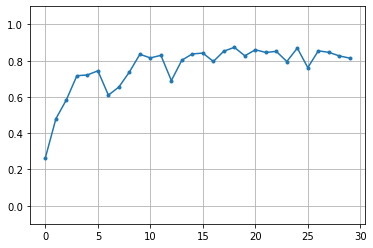

In [60]:
plt.plot(df_progress.iou, ".-")
plt.ylim(-0.1, 1.1)
plt.grid()

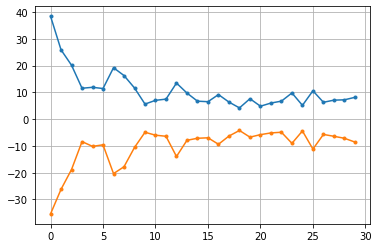

In [61]:
plt.plot(df_progress.onset, ".-")
plt.plot(df_progress.offset, ".-")
plt.grid()

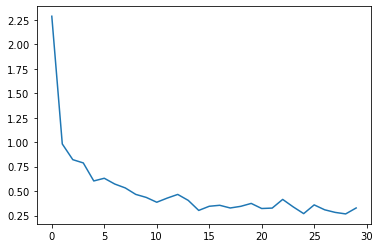

In [62]:
plt.plot(df_progress["n_diff"])

In [46]:
y_pred = model.predict(df[["x", "y", "z"]][:], 128)

In [47]:
y_pred = np.nanmean(y_pred, axis=0)

/var/folders/bb/nyjl24854274krnpfgh1w7gr0000gn/T/ipykernel_6629/2955189255.py:1: RuntimeWarning: Mean of empty slice
  y_pred = np.nanmean(y_pred, axis=0)


In [51]:
y_true = df["proba"].values

In [52]:
metrics, df_metrics = calculate_metrics(
    (y_pred > 0.5).astype(int),
    (y_true > 0.5).astype(int)
)

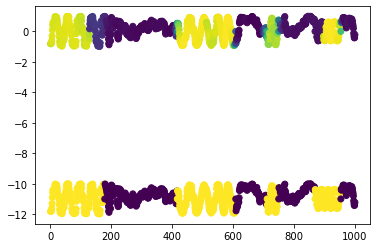

In [55]:
i = 1000

plt.scatter(
    df[:i].index,
    df[:i]["x"],
    c=y_pred[:i]
)

plt.scatter(
    df[:i].index,
    df[:i]["x"] - 11,
    c=df[:i]["proba"] > 0
)

In [133]:
df[:i]["proba"]

0      399.562386
1      399.562386
2      399.562386
3      399.562386
4      399.562386
          ...    
995      0.000000
996      0.000000
997      0.000000
998      0.000000
999      0.000000
Name: proba, Length: 1000, dtype: float64

In [126]:
metrics

{'n_diff': -28,
 'iou_mean': 0.5200241652078408,
 'iou_std': 0.35283806051125705,
 'offset_mean': -36.819383259911895,
 'offset_std': 54.89277505922503,
 'onset_mean': 51.65638766519824,
 'onset_std': 80.85492959009586}

In [125]:
df_metrics.

,ref,iou,offset,onset,intersection,union
0,False,0.715084,-51.0,0.0,128.0,179.0
1,False,0.901408,7.0,-14.0,192.0,213.0
2,False,0.603175,18.0,-7.0,38.0,63.0
3,False,0.670588,-1.0,27.0,57.0,85.0
4,False,0.950495,-19.0,1.0,384.0,404.0
...,...,...,...,...,...,...
468,False,0.772152,6.0,30.0,122.0,158.0
469,False,0.666667,-59.0,5.0,128.0,192.0
470,False,0.981982,0.0,-2.0,109.0,111.0
471,False,0.929648,-7.0,-7.0,185.0,199.0


In [156]:
aaaplt.plot(dataset_test_real.df_concat.x[:1000])

NameError: name 'dataset_test_real' is not defined

In [185]:
from scipy.interpolate import interp1d

In [186]:
# folder = "/Volumes/samsung-T5/HPL/Rheeda/pipeline/M15/G3/S15/trajectories"
folder = "/Volumes/samsung-T5/HPL/Rheeda/pipeline/M13/G3/S13/trajectories"
folder = "/Volumes/samsung-T5/HPL/Rheeda/pipeline/M15/G3/S39/trajectories"
folder = "/Volumes/samsung-T5/HPL/Rheeda/pipeline/M15/G2/S01/trajectories"

filenames = os.listdir(folder)

dfs = []

for i, filename in enumerate(filenames[:]):
    
    filename = os.path.join(folder, filename)
    df = pd.read_csv(filename)
    if df.t.max() < 2500.:
        continue
        
    df["i"] = i
        
    dfs.append(df)

In [187]:
xyz = ["x", "y", "z"]

dfs_interp = []

for df in dfs:
    f = interp1d(df.t, df[xyz], axis=0)
    t = np.arange(df.t.min(), df.t.max(), 10)
    X = f(t)
    
    df_interp = pd.DataFrame(X, columns=xyz)
    df_interp["t"] = t
    dfs_interp.append(df_interp)

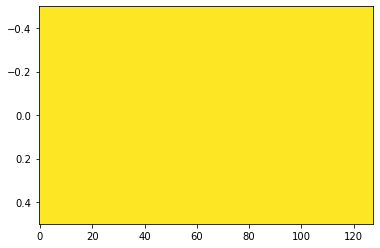

In [188]:
plt.imshow(y, aspect="auto", vmin=0, vmax=1)

In [189]:
for df in dfs_interp:
    y = model.predict(df[["x", "y", "z"]], 4)
    y_ = np.nanmean(y, axis=0)
    df["proba"] = y_.copy()

/var/folders/bb/nyjl24854274krnpfgh1w7gr0000gn/T/ipykernel_3727/732173932.py:3: RuntimeWarning: Mean of empty slice
  y_ = np.nanmean(y, axis=0)
/var/folders/bb/nyjl24854274krnpfgh1w7gr0000gn/T/ipykernel_3727/732173932.py:3: RuntimeWarning: Mean of empty slice
  y_ = np.nanmean(y, axis=0)
/var/folders/bb/nyjl24854274krnpfgh1w7gr0000gn/T/ipykernel_3727/732173932.py:3: RuntimeWarning: Mean of empty slice
  y_ = np.nanmean(y, axis=0)
/var/folders/bb/nyjl24854274krnpfgh1w7gr0000gn/T/ipykernel_3727/732173932.py:3: RuntimeWarning: Mean of empty slice
  y_ = np.nanmean(y, axis=0)


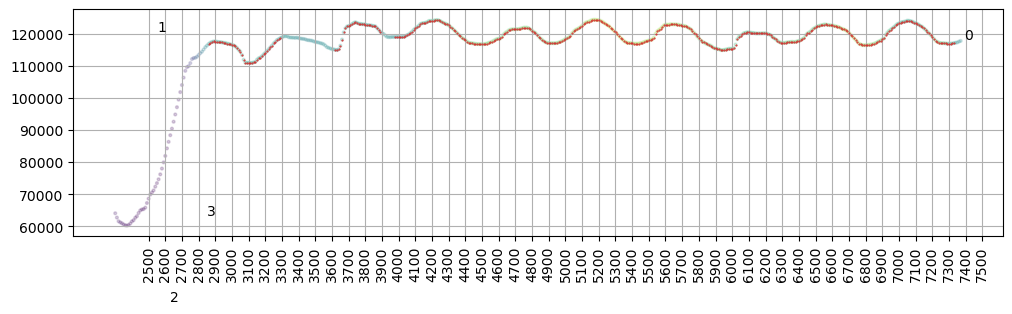

In [190]:
plt.figure(figsize=(12, 3), dpi=100)

cy = "y"

for i, df in enumerate(dfs_interp):
    
    proba = df["proba"]
    
    plt.scatter(
        df.t,
        df[cy], # + i * 500,
        c=proba,
        s=4,
        alpha=0.2,
        vmin=0,
        vmax=1
    )
    
    mask = proba > 0.5
    plt.plot(df.t[mask], df[cy][mask], ".", color="C3", ms=1)
    
    plt.text(df.t.iloc[-1], df[cy].iloc[-1], str(i), ha="left")
    
plt.xticks(np.arange(2500, 7600, 100), rotation=90)
plt.grid()

In [58]:
df_ = df[-4000:]
# df_ = dataset_test_real.df_concat[-2000:]

y = model.predict(df_[["x", "y", "z"]], 4)

In [68]:
y.shape

(39, 510)

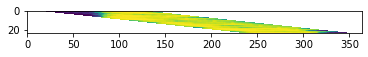

In [76]:
plt.imshow(y)

In [109]:
y_ = np.nanmean(y, axis=0)
# y_ = np.nanmax(y, axis=0)

/var/folders/bb/nyjl24854274krnpfgh1w7gr0000gn/T/ipykernel_2728/1273601722.py:1: RuntimeWarning: Mean of empty slice
  y_ = np.nanmean(y, axis=0)


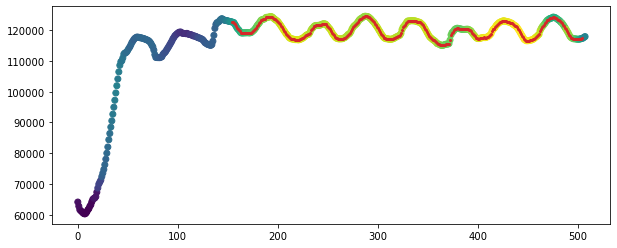

In [185]:
plt.figure(figsize=(10, 4))

cy = "y"

plt.scatter(df.index, df[cy], c=df.proba)
mask = df.proba > 0.5
plt.plot(df.index[mask], df[cy][mask], ".", color="C3", ms=4)

# c = "proba"
# plt.scatter(df.index, df.x - 100, c=df[c] > 0.5)

(57058.1326305261, 127751.37221991958, 32178.451054553567, 73391.63137835459)

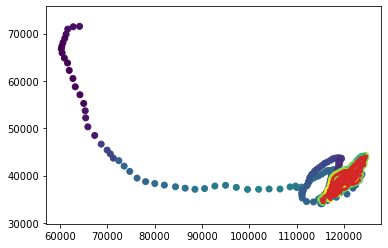

In [179]:
df = dfs_interp[0].dropna()

plt.scatter(df.y, df.x, c=df.proba)
mask = df.proba > 0.5
plt.plot(df.y[mask], df.x[mask], ".-", color="C3", ms=4)
plt.axis("equal")

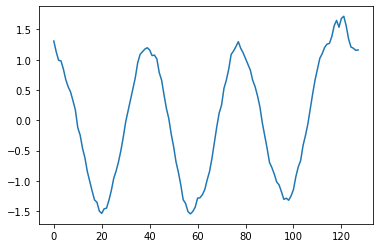

In [104]:
plt.plot(dataset_test.X[0][2])

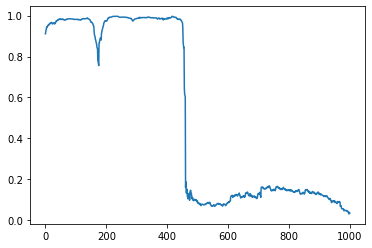

In [88]:
plt.plot(y_)

In [67]:
dataset = dataset_test
# dataset = dataset_train

y_pred = model(dataset.X).detach()
y_true = dataset.Y

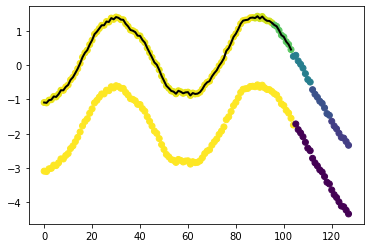

In [78]:
i = 139

x = dataset.X[i]
t = np.arange(x.shape[-1])

ix = 2

mask = y_pred[i] > 0.5

plt.scatter(t, x[ix], c=y_pred[i], vmin=0, vmax=1)
plt.plot(t[mask], x[ix][mask], "-k", lw=2)

plt.scatter(t, x[ix] - 2, c=y_true[i], vmin=0, vmax=1)

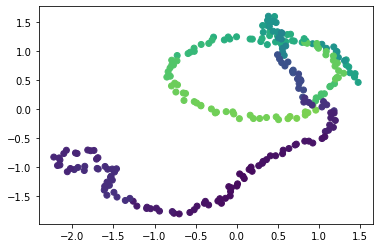

In [62]:
plt.scatter(x[0], x[2], c=y_pred[i], vmin=0, vmax=1)

(-0.1, 1.1)

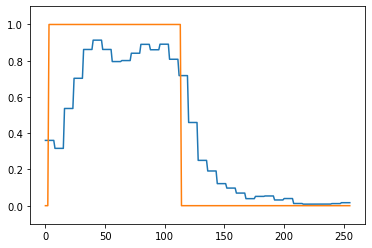

In [63]:
plt.plot(y_pred[0])
plt.plot(y_true[0])

plt.ylim(-0.1, 1.1)

In [147]:
x = dataset_test.X[16]
y_pred = model(x.unsqueeze(0)).detach().numpy()

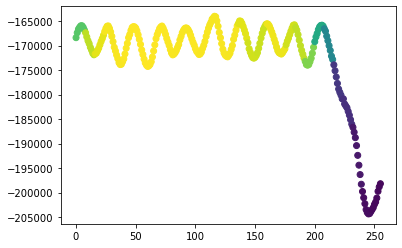

In [148]:
plt.scatter(
    np.arange(x.shape[-1]),
    x[0],
    c=y_pred[0].squeeze(),
    vmin=0,
    vmax=1
)

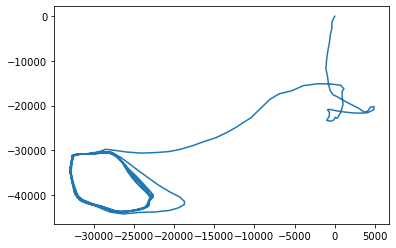

In [73]:


plt.plot(x[0], x[1])